# Heterogenous Modelling
Using different kinds of distributions to model data, instead of only a single kind of distribution.


In [12]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

import sys
sys.path.append('../')
import utils as utl
import datasets as d
import models as m

tfd = tfp.distributions
tfm = tf.math

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get Toy Data

In [13]:
data = d.gen_checkerboard_d3split(batch_size=20000)
batched = d.to_tf_dataset(data, batch_size=200)

## Define Model

In [14]:
# Number of components per distribution
K_TT = 10
K_CP = 59
# Number of dimensions of the data (features)
M = data.shape[1]

In [15]:
# Define a distribution for each dimension of the data
dists = [
    tfd.Normal,     # dimension 1
    tfd.Normal,     # dimension 2
    tfd.Categorical # dimension 3
]

In [17]:
# Define the parameters used by the models
params_TT = [
    [
        # distribution 1 (normal)
        np.random.uniform(-4, 4, (K_TT, K_TT)),
        np.random.uniform(0, 4, (K_TT, K_TT))
    ], [
        # distribution 2 (normal)
        np.random.uniform(-4, 4, (K_TT, K_TT)),
        np.random.uniform(0, 4, (K_TT, K_TT))
    ], [
        # distribution 3 (categorical)
        np.ones((K_TT, K_TT, 3))
    ]
]

params_CP = [
    [
        np.random.uniform(-4, 4, (K_CP, )),
        np.random.uniform(0, 4, (K_CP, ))
    ], [
        np.random.uniform(-4, 4, (K_CP, )),
        np.random.uniform(0, 4, (K_CP, ))
    ], [
        np.ones((K_CP, 3))
    ],
]

In [18]:
# Define the modifyer used for each dimension
# set to None for categorical
modifiers = {
    0: {1: tfm.softplus},
    1: {1: tfm.softplus}
}

In [19]:
# Instantiate models
TT = m.TensorTrainGeneral(K_TT, dists, params_TT, modifiers)
CP = m.CPGeneral(K_CP, dists, params_CP, modifiers)

## Fit models to data

In [20]:
# Define number of epochs to train on
EPOCHS = 250

In [21]:
# Training optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [22]:
# train TT general version
losses_TT = TT.fit(batched, EPOCHS, optimizer)

Training TT: 100%|██████████| 250/250 [01:15<00:00,  3.33it/s]Training time elapsed: 75 seconds
Final loss: 3.599759216308594



In [23]:
# train TT fixed gaussian version 
losses_CP = CP.fit(batched, EPOCHS, optimizer)

Training CPGeneral: 100%|██████████| 250/250 [00:51<00:00,  4.88it/s]Training time elapsed: 51 seconds
Final loss: 3.6245733642578126



## Display Results

### Loss Plot

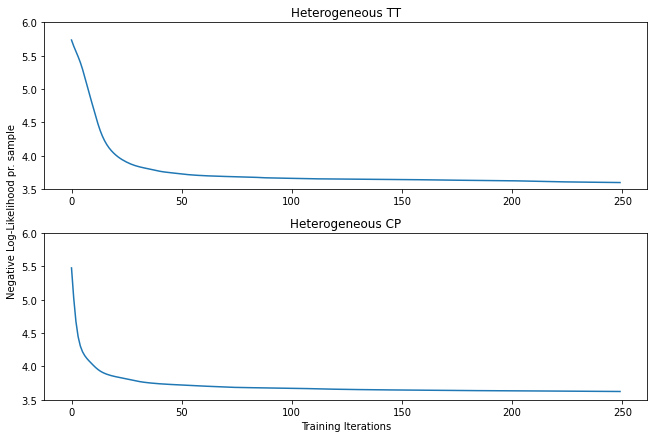

In [29]:
f, ax = plt.subplots(2, 1, figsize=(9,6))
ax[0].plot(losses_TT)
ax[0].set_title("Heterogeneous TT")
ax[0].set_ylim([3.5, 6])
ax[1].plot(losses_CP)
ax[1].set_title("Heterogeneous CP")
ax[1].set_ylim([3.5, 6])
f.tight_layout()
f.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Training Iterations")
plt.ylabel("Negative Log-Likelihood pr. sample")
plt.show()

### Density Plots

In [38]:
def plot_density_3d(data, model, title):
    # Define indices for the categories
    idxs = []
    idxs.append(data[:, 2] == 0)
    idxs.append(data[:, 2] == 1)
    idxs.append(data[:, 2] == 2)
    
    # check integrand of density
    limit = 6
    n_points = 300
    x, dx = np.linspace(-limit, limit, n_points, retstep=True)
    y, dy = np.linspace(-limit, limit, n_points, retstep=True)

    x_grid, y_grid = np.meshgrid(x, y)

    print(title)
    integrals = []
    f, ax = plt.subplots(1, M, figsize=(15, 5))
    for i in range(M):
        X = np.array([x_grid.ravel(), y_grid.ravel(), i * np.ones((n_points**2,))]).T

        # Get density
        p_log = model(X).numpy()
        p = np.exp(p_log)

        # Compute integrand
        integral = np.sum(p)*dx*dy
        integrals.append(integral)

        im = ax[i].imshow(
            p.reshape(n_points, n_points),
            extent=(-limit, limit, -limit, limit),
            origin='lower',
            cmap='gray'
        )
        cbar = plt.colorbar(im, ax=ax[i])
        cbar.ax.set_ylabel('inferno')
    f.tight_layout()
    print("Sum of categories is {}".format(np.sum(integrals)))

Heterogeneous CP Decomposition
Sum of categories is 0.999922815285903


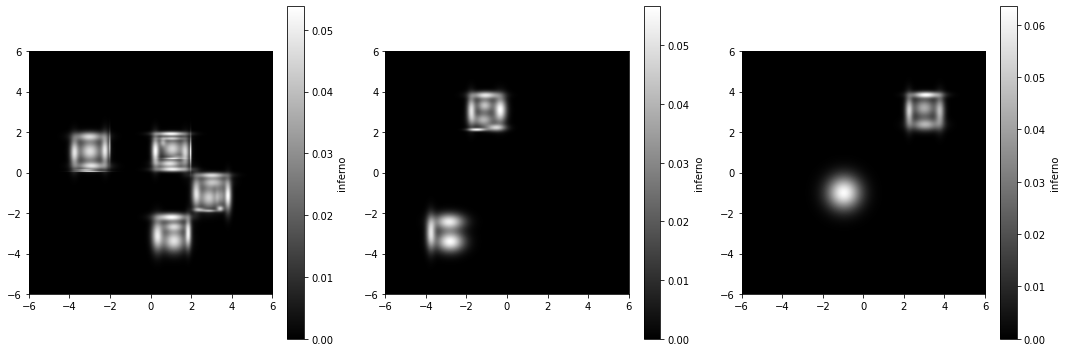

In [39]:
plot_density_3d(data, CP, "Heterogeneous CP Decomposition")

Heterogeneous TT Decomposition
Sum of categories is 0.9999985635734641


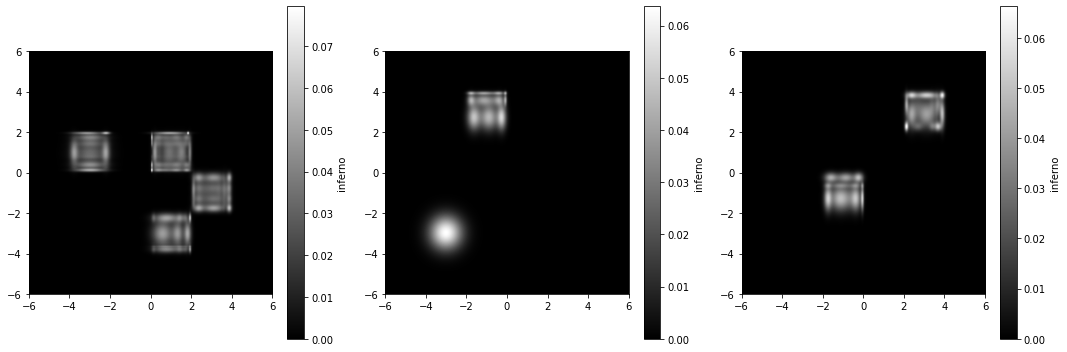

In [40]:
plot_density_3d(data, TT, "Heterogeneous TT Decomposition")

### Sampling

In [41]:
# sample from the models
N_samples = 1000
TT_samples = TT.sample(N_samples)
CP_samples = CP.sample(N_samples)

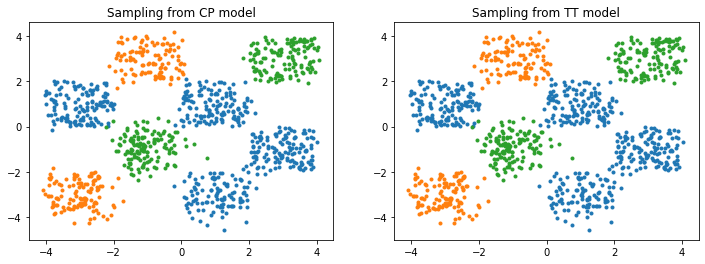

In [46]:
# plot the samples
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(CP_samples[CP_samples[:, 2] == 0, 0], CP_samples[CP_samples[:, 2] == 0, 1], '.')
ax[0].plot(CP_samples[CP_samples[:, 2] == 1, 0], CP_samples[CP_samples[:, 2] == 1, 1], '.')
ax[0].plot(CP_samples[CP_samples[:, 2] == 2, 0], CP_samples[CP_samples[:, 2] == 2, 1], '.')
ax[0].set_title('Sampling from CP model')

ax[1].plot(CP_samples[CP_samples[:, 2] == 0, 0], CP_samples[CP_samples[:, 2] == 0, 1], '.')
ax[1].plot(CP_samples[CP_samples[:, 2] == 1, 0], CP_samples[CP_samples[:, 2] == 1, 1], '.')
ax[1].plot(CP_samples[CP_samples[:, 2] == 2, 0], CP_samples[CP_samples[:, 2] == 2, 1], '.')
ax[1].set_title('Sampling from TT model')

plt.show()